In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cv2
from scipy.linalg import expm,logm,block_diag
from numpy.linalg import inv
from scipy.optimize import least_squares


In [2]:
mat = scipy.io.loadmat('dataset3.mat')
t = mat['t']                
true_theta = mat['theta_vk_i']      
true_r = mat['r_i_vk_i']      
w_meas = mat['w_vk_vk_i']
w_var = mat['w_var']
v_meas = mat['v_vk_vk_i']
v_var = mat['v_var']
rho = mat['rho_i_pj_i']
y_k_j = mat['y_k_j']
y_var = mat['y_var']
C_c_v = mat['C_c_v']
rho_v_c_v = mat['rho_v_c_v']
fu = mat['fu'].item()
fv = mat['fv'].item()
cu = mat['cu'].item()
cv = mat['cv'].item()
b = mat['b'].item()

In [3]:
t.shape

(1, 1900)

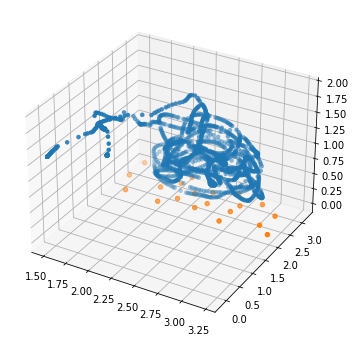

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_r[0,:], true_r[1,:], true_r[2,:],linewidth = 0.02)
ax.scatter(rho[0,:],rho[1,:],rho[2,:])
plt.show()

In [5]:
def hat_so3(w):
    return np.array([[0,-w[2],w[1]], 
                     [w[2],0,-w[0]], 
                     [-w[1],w[0],0]])

def inv_so3(C):
    return np.array([C[2,1],C[0,2],C[1,0]])

In [6]:
#Both alternatives work!
def recover(psi):
    norm = np.linalg.norm(psi)
    first = np.cos(norm) * np.eye(3)
    second = (1 - np.cos(norm)) * (psi / norm).reshape(3,1) @ (psi / norm).reshape(1,3)
    third = -np.sin(norm) * hat_so3(psi / norm)
    return first + second + third
#     return expm(hat_so3(-psi))

In [7]:
def world2img(pos, theta, r):
    p_ck = C_c_v @ ((recover(theta) @ (pos - r)).reshape(3,1) - rho_v_c_v)
    res = np.array([fu * p_ck[0]/p_ck[2] + cu, 
                    fv * p_ck[1]/p_ck[2] + cv,
                    fu * (p_ck[0]-b)/p_ck[2] + cu,
                    fv * p_ck[1]/p_ck[2] + cv])
    return np.squeeze(res)

In [8]:
def motion_model(r_k1, C_k1, k):
    d_k = v_meas[:,k-1] * (t[0,k]-t[0,k-1])
    r_k = r_k1 + C_k1.T @ d_k
    C_k = recover(w_meas[:,k-1] * (t[0,k]-t[0,k-1])) @ C_k1
    return r_k, C_k

def dead_reckon(k1, k2, C_k0=None, r_k0=None):
    if C_k0 is None and r_k0 is None:
        res_r = [true_r[:,k1]]
        res_C = [recover(true_theta[:,k1])]
    else:
        res_r = [r_k0]
        res_C = [C_k0]

    for k in range(k1+1,k2):
        r_op = res_r[-1]
        C_op = res_C[-1]
        r_k, C_k = motion_model(r_op, C_op, k)
        res_r.append(r_k)
        res_C.append(C_k)
        
    return np.array(res_r), np.array(res_C) 

In [9]:
def batch_inv_so3(C):
    res = []
    for i in range(C.shape[0]):
        res.append(inv_so3(logm(C[i,:,:].T)))
    return np.array(res)

The residual error vector. Nx1 with the sqrt of Weght Matrix(inverse of covariance)

In [10]:
def build_error(x, k1, k2):
    error_list = []
    error_total = []
    for k in range(k2-k1):
        #imu(motion model) error
        if (k==0):
            dt = t[0,k1]-t[0,k1-1]
            C_est = recover(x[0:3])
            r_est = x[3:6]
            C_gt = recover(true_theta[:,k1])
            r_gt = true_r[:,k1]
            C_error = inv_so3(logm((C_gt @ C_est.T)).T)
            r_error = r_gt - r_est
            Cr_error = np.hstack((C_error, r_error))
            Cr_error = Cr_error * np.sqrt(1.0 / (dt**2 * (np.vstack((v_var, w_var)).ravel() + 1e-5)))
            error_total.append(Cr_error)
        else:
            dt = t[0, k1+k] - t[0, k1+k-1]
            r_k, C_k = motion_model(r_est, C_est, k1+k)
            C_est = recover(x[6*k:6*k+3])
            r_est = x[3 + 6*k :6 + 6*k]
            C_error = inv_so3(logm((C_k @ C_est.T)).T)
            r_error = r_k - r_est
            error_tmp = np.hstack((C_error, r_error))
            error_tmp = error_tmp * np.sqrt(1.0 / (dt**2 * (np.vstack((v_var, w_var)).ravel() + 1e-5)))
            error_total.append(error_tmp)
        
        #measurement error
        C_est_meas = recover(x[6*k:6*k+3])
        r_est_meas = x[3 + 6*k :6 + 6*k]
        for j in range(20):
            y_k_j_meas = y_k_j[:, k1 + k, j]
            if y_k_j_meas[0] < -1e-3: continue
            y_k_j_est = world2img(rho[:,j], x[6*k:6*k+3], r_est_meas)
            error_meas = y_k_j_meas - y_k_j_est
            error_meas = error_meas * np.sqrt(1.0 / (y_var.ravel() + 1e-5))
            error_total.append(error_meas)
            
    error_vector = np.hstack(error_total)
    return error_vector
            

In [11]:
def scipy_optimization(C_op, r_op, k1, k2):
    r_est_list = []
    C_est_list = []
    
    #build the initial state vector from dead reckon.
    phi = batch_inv_so3(C_op)
    xi_init = np.concatenate((phi,r_op),axis=1).flatten()
    res = least_squares(build_error, x0=xi_init, method='lm', verbose=2, args=(k1, k2))

    #Reconstruct Rotations and Translations
    for k in range(k2 - k1):
        C_est = recover(res.x[0 + 6*k :3 + 6*k])
        r_est = res.x[3 + 6*k :6 + 6*k]
        C_est_list.append(C_est)
        r_est_list.append(r_est.reshape(-1, 1))
    C_est_stack = np.stack(C_est_list, axis = 0)
    r_est_stack = np.hstack(r_est_list)

    return C_est_stack, r_est_stack

In [12]:
k1, k2 = 1000, 1005
r_op, C_op = dead_reckon(k1, k2)
#If I expand the interval between k1 and k2, the cost time grows dramatically
C_est, r_est = scipy_optimization(C_op, r_op, k1, k2)

`ftol` termination condition is satisfied.
Function evaluations 125, initial cost 5.5905e+02, final cost 2.2859e+01, first-order optimality 5.42e-04.


In [13]:
def pgpp(p):
    jac = np.array([[fu,0,-fu*p[0]/p[2]],
                    [0,fv,-fv*p[1]/p[2]],
                    [fu,0,-fu*(p[0]-b)/p[2]],
                    [0,fv,-fv*p[1]/p[2]]],dtype = np.float)
    return jac / p[2]

In [14]:
def plot_error(r_op, C_op, k1, k2, Hessian):

    rot_error = []
    trans_error = []
    for k in range(k2 - k1):
        r_gt_k = true_r[:, k1 + k]
        r_op_k = r_op[k, :]
        trans_error.append(r_op_k - r_gt_k)

        C_gt_k = recover(true_theta[:, k1+k])
        C_op_k = C_op[k,:,:]
        rot_error.append(inv_so3(np.eye(3) - C_op_k @ C_gt_k.T))

    err = np.hstack((np.array(trans_error),np.array(rot_error)))

    std = np.sqrt(np.diag(inv((Hessian))))
    std_set = [std[i::6] for i in range(6)]

    timestamps = np.arange(k1, k2)
    dim = ["x", "y", "z"]
    error_type = ["translation", "rotation"]
    unit = ["m","rad"]

    fig, ax = plt.subplots(3, 2, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.4)

    for i in range(3):
        for j in range(2):
            ax[i][j].plot(timestamps, err[:,j*3 + i], label = error_type[j] +" " + dim[i] + " error")
            ax[i][j].plot(timestamps, -3 * std_set[j*3 + i], ':', color='magenta')
            ax[i][j].plot(timestamps,  3 * std_set[j*3 + i], ':', color='magenta')
            ax[i][j].set_xlabel("Timestamps")
            ax[i][j].set_ylabel(f"Error [{unit[j]}]" )
            ax[i][j].set_title(f"{dim[i]} dimension {error_type[j]} error")
            ax[i][j].legend()
    plt.show()

In [15]:
def batch_LM(C_op,r_op,k1,k2,iter_num=7,thres=0.01):
    e_prev = []
    delta_x_prev = []
    
    for iter_ in range(iter_num):
        Fs = []
        Gs = []
        Q_invs = []
        R_invs = []
        e_v_ks = []
        e_y_ks = []
        
        #at timestamp 0 using ground truth
        dt = t[0, k1] - t[0, k1 - 1]
        C_op0 = C_op[0, :, :]
        r_op0 = r_op[0, :]

        C_gt0 = recover(true_theta[:,k1])
        r_gt0 = true_r[:, k1]
        e_v_ks.append(r_gt0 - r_op0)
        e_v_ks.append(inv_so3(logm(C_gt0 @ C_op0.T).T))
        Q_invs.append(np.diag(1.0 / (dt**2 * np.vstack((v_var, w_var)).ravel())))
        
        #start loop
        for k in range(k2-k1):
            #pose at timestamp k
            dt = t[0, k + k1] - t[0, k + k1 - 1]
            C_op_k = C_op[k, :, :]
            r_op_k = r_op[k, :]
            d_k = v_meas[:, k1 + k] * dt 
            
            #compute the measurement model part error term
            G_k_j = []
            e_y_k_j = []
            for j in range(20):
                y_k_j_meas = y_k_j[:, k1 + k, j]
                if y_k_j_meas[0] < -1e-3: continue

                #Get the estimated points in camera frame
                p_c_j_est = C_c_v @ (C_op_k @ (rho[:, j] - r_op_k) - rho_v_c_v.ravel())
                
                #Jacobian matrix G_k_j
                G_k_j_r = pgpp(p_c_j_est) @ C_c_v @ C_op_k
                G_k_j_C = pgpp(p_c_j_est) @ C_c_v @ hat_so3(C_op_k @ (rho[:, j] - r_op_k))
                G_k_j.append(np.hstack((G_k_j_r, G_k_j_C)))
                #print(G_k_j[-1])

                #Calculate the error term
                y_k_j_est = world2img(rho[:,j], inv_so3(logm(C_op_k).T), r_op_k)
                e_y_k_j.append(y_k_j_meas - y_k_j_est)

                #R matrix
                R_invs.append(np.diag(1.0 / (y_var.ravel())))
                
            if(len(G_k_j) > 0):
                #Stack all jacobians and errors
                G_k = np.vstack(G_k_j)
                e_y_k = np.hstack(e_y_k_j)
                Gs.append(G_k)
                e_y_ks.append(e_y_k) 
            else:
                Gs.append(np.zeros((0,6)))
            
            if k==0: continue
                
            #compute the motion model part error term
            r_motion, C_motion = motion_model(r_op[k-1,:],C_op[k-1, :, :],k + k1)
            e_v_k_r = r_motion - r_op_k
            e_v_k_C = inv_so3(logm(C_motion @ C_op_k.T).T)
            e_v_ks.append(e_v_k_r)
            e_v_ks.append(e_v_k_C)
            
            #Jacobian matrix F_k
            F_k = np.eye(6)
            F_k[0:3, 3:6] = C_op[k-1, :, :].T @ hat_so3(d_k)
            F_k[3:6, 3:6] = C_op_k @ C_op[k-1, :, :].T
            Fs.append(F_k)
            
            #Q martix
            Q_invs.append(np.diag(1.0 / (dt**2 * np.vstack((v_var, w_var)).ravel())))
                
        #H matrix
        F = np.eye((k2 - k1) * 6)
        for i in range(len(Fs)):
            F[6*i+6: 6*i+12, 6*i: 6*i+6] = -Fs[i]
        G = block_diag(*Gs)
        H = np.vstack((F, -G))
        
        #Construct e_op
        e_v = np.hstack(e_v_ks)
        if len(e_y_ks) == 0:
            e_op = e_v
        else:
            e_y = np.hstack(e_y_ks)
            e_op = np.hstack((e_v, e_y))
            print(f"Average error of motion: {np.average(np.abs(e_v))}")
            print(f"Average error of measurements: {np.average(np.abs(e_y))}")
            print("--------------------------------------------------------")
            
        # compute W_inv
        W_inv = block_diag(*(Q_invs + R_invs))

        # compute Hessian and b
        Hessian = H.T @ W_inv @ H
        b = H.T @ W_inv @ e_op.T

        # construct LM's Hessian matrix, using 1e-3 as lambda here
        Hessian_LM = Hessian + 1e-3 * np.eye(Hessian.shape[0])

        # get the delta x, possible to time a learning rate, but not necessary
        delta_x = np.linalg.inv(Hessian_LM) @ b

        # update to operation point set
        for k in range(k2 - k1):
            r_op[k,:] = delta_x[6*k:6*k+3] + r_op[k,:]
            C_op[k,:,:] = recover(delta_x[6*k+3:6*k+6]).T @ C_op[k,:,:]
            
        # iteration stops at a small enough step
        delta_x_curr = np.average(np.abs(delta_x))
        if len(delta_x_prev)>0:
            if abs(delta_x_curr-delta_x_prev[-1]) < thres:
                print(f"LM coverages at {iter_} iteration")
                break
        delta_x_prev.append(delta_x_curr)
            
    return r_op, C_op, Hessian

Average error of motion: 1.9274549700398075e-16
Average error of measurements: 207.68270037763344
--------------------------------------------------------
Average error of motion: 0.00426584417704546
Average error of measurements: 66.50387337033567
--------------------------------------------------------
Average error of motion: 0.004098196242886242
Average error of measurements: 8.670506585473829
--------------------------------------------------------
Average error of motion: 0.004707105009056571
Average error of measurements: 1.5350587716936865
--------------------------------------------------------
LM coverages at 3 iteration


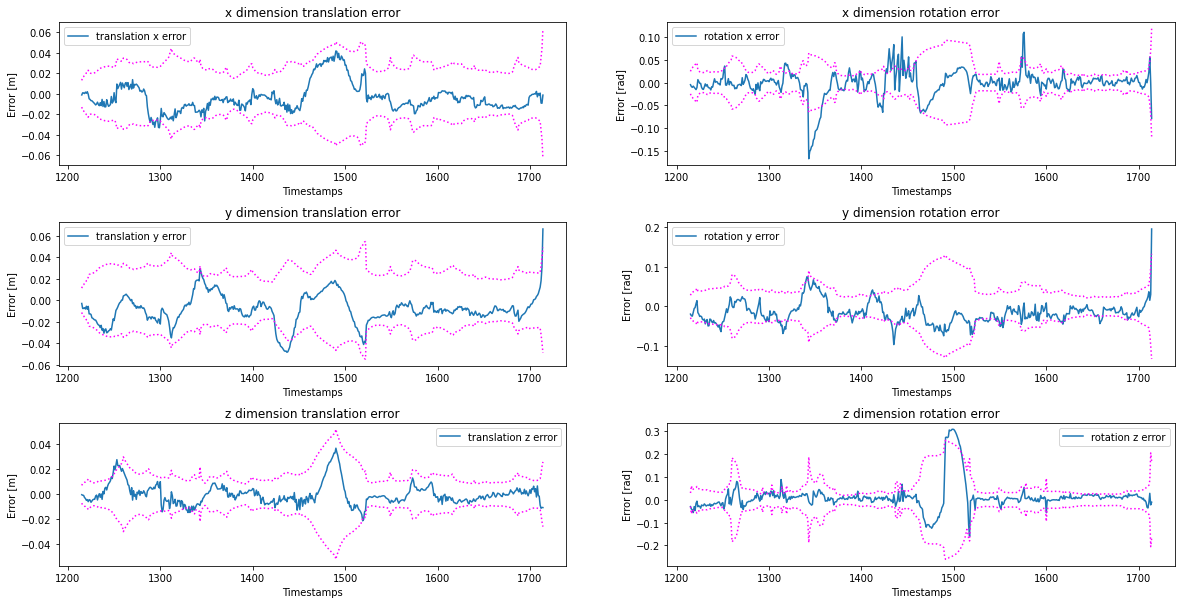

In [16]:
k1, k2 = 1215, 1715
r_op, C_op = dead_reckon(k1, k2)
r_batch, C_batch, Hessian = batch_LM(C_op, r_op, k1, k2)
plot_error(r_batch, C_batch, k1, k2, Hessian)

<IPython.core.display.Javascript object>


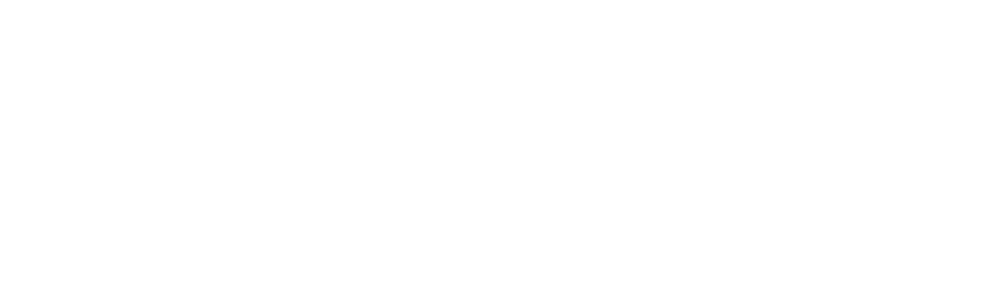

In [17]:
#Animation of ground truth pose and measurement
#red: ground truth, blue: measurement


from matplotlib import animation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
dot1, = ax1.plot([], [], 'ro')
dot2, = ax2.plot([], [], 'ro')
dot = [dot1, dot2]

dot_true1, = ax1.plot([], [], 'bo')
dot_true2, = ax2.plot([], [], 'bo')
dot_true = [dot_true1, dot_true2]


def init():
    ax1.set_xlim(0, 640)
    ax1.set_ylim(0, 480)
    ax2.set_xlim(0, 640)
    ax2.set_ylim(0, 480)

def update_dot(k):
    res_list = []
    meas_list = []
    for i in range(20):
        res = world2img(rho[:,i], true_theta[:,k], true_r[:,k])
        res_list.append(res)
        meas_list.append(y_k_j[:,k,i])
    res_array = [np.array(res_list), np.array(meas_list)]

    dot_true[0].set_data(res_array[0][:,0], res_array[0][:,1])
    dot_true[1].set_data(res_array[0][:,2], res_array[0][:,3])
    dot[0].set_data(res_array[1][:,0], res_array[1][:,1])
    dot[1].set_data(res_array[1][:,2], res_array[1][:,3])

    return dot_true, dot

ani = animation.FuncAnimation(fig, update_dot, frames = np.arange(0, 1900, 1), interval = 100, init_func=init, blit=True)

<IPython.core.display.Javascript object>


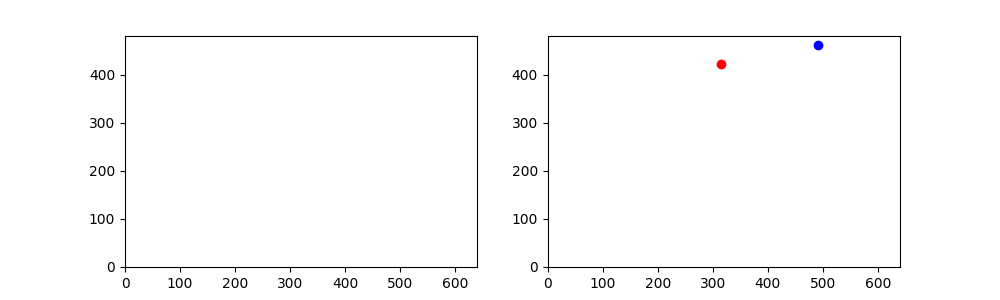

In [18]:
#Animation of ground truth pose and estimated pose
#red: ground truth, blue: estimated pose


from matplotlib import animation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
dot1, = ax1.plot([], [], 'ro')
dot2, = ax2.plot([], [], 'ro')
dot = [dot1, dot2]

dot_true1, = ax1.plot([], [], 'bo')
dot_true2, = ax2.plot([], [], 'bo')
dot_true = [dot_true1, dot_true2]

psi_batch = batch_inv_so3(C_batch)

def init():
    ax1.set_xlim(0, 640)
    ax1.set_ylim(0, 480)
    ax2.set_xlim(0, 640)
    ax2.set_ylim(0, 480)

def update_dot(k):
    res_list = []
    meas_list = []
    for i in range(20):
        res_true = world2img(rho[:,i], true_theta[:,k1+k], true_r[:,k1+k])
        res_list.append(res_true)
        
        res_op = world2img(rho[:,i], psi_batch[k,:], r_batch[k,:])
        meas_list.append(res_op)
    res_array = [np.array(res_list), np.array(meas_list)]

    dot_true[0].set_data(res_array[0][:,0], res_array[0][:,1])
    dot_true[1].set_data(res_array[0][:,2], res_array[0][:,3])
    dot[0].set_data(res_array[1][:,0], res_array[1][:,1])
    dot[1].set_data(res_array[1][:,2], res_array[1][:,3])

    return dot_true, dot

ani = animation.FuncAnimation(fig, update_dot, frames = np.arange(0, k2-k1, 1), interval = 100, init_func=init, blit=True)